Initial imports of necessary packages


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
from sklearn.metrics import accuracy_score,  f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, log_loss
import random
import time
import collections
import warnings
from scipy.stats import pearsonr, spearmanr

%matplotlib inline

Read in Train, Test and Label csv files as Pandas dataframes

In [ ]:
train_tcga_df = pd.read_csv('../data/train_tcga_expression_matrix_processed.tsv', header=0, sep='\t')
test_tcga_df = pd.read_csv('../data/test_tcga_expression_matrix_processed.tsv', header=0, sep='\t')

labels_tcga_df = pd.read_csv('../data/tcga_sample_identifiers.tsv', header=0, sep='\t')

The final TCGA PanCanAtlas gene expression matrix with 11060 samples, which included 33 different cancer types, and 16148 genes.

With a 90/10 train/test split, this results in 9954/1106 train test sample split, with 16149 cols (1 added col for 'sample_id')



Load first 5 samples in each of the dataframes to obtain a feel for the structure of the data



In [ ]:
train_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,3430.0,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,6050.0,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,4930.0,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,3890.0,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,1930.0,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0


In [ ]:
test_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,2730.0,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,4510.0,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,4420.0,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,5460.0,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,5200.0,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0


In [ ]:
labels_tcga_df.head()

,sample_id,sample_type,cancer_type
0,TCGA-02-0047-01,Primary Solid Tumor,GBM
1,TCGA-02-0055-01,Primary Solid Tumor,GBM
2,TCGA-02-2483-01,Primary Solid Tumor,GBM
3,TCGA-02-2485-01,Primary Solid Tumor,GBM
4,TCGA-02-2486-01,Primary Solid Tumor,GBM


Print shape of each of the dfs

In [ ]:
print("Train df Shape", train_tcga_df.shape)
print("Test df Shape", test_tcga_df.shape)
print("Labels df Shape", labels_tcga_df.shape)

Train df Shape (9954, 16149)
Test df Shape (1106, 16149)
Labels df Shape (11060, 3)


Obtain the list of 'Sample ID' (Indicator Variable)  in each of the dataframes, and use them to append the cancer type (aka the Y variable) from the labels df onto the train and test df

In [ ]:
train_id = train_tcga_df['sample_id']
test_id = test_tcga_df['sample_id']
label_id = labels_tcga_df['sample_id']

In [ ]:
merge_train = []
merge_test = []

for i in train_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_train.append(str(val['cancer_type']).split()[1])
    
for i in test_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_test.append(str(val['cancer_type']).split()[1])

Create new col in train and test with the cancer type added in

In [ ]:
train_tcga_df['cancer_type'] = merge_train
print(train_tcga_df.shape)
train_tcga_df.head()

(9954, 16150)


,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0,BRCA
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0,LUAD
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0,DLBC
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0,UCEC
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0,SKCM


In [ ]:
test_tcga_df['cancer_type'] = merge_test
print(test_tcga_df.shape)
test_tcga_df.head()

(1106, 16150)


,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0,HNSC
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0,CESC
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0,LUSC
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0,LGG
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0,OV


To conserve RAM usage, we delete computed variables when are done using them. First we delete the labels matrix, as we have already appended cancer type to train and test matrices

In [ ]:
del labels_tcga_df

Functions to return dataframe with only the presence or absence of a particular cancr type. We also shuffle the dataframe before returning it

In [ ]:
def returnDf2(df, ind, c_type):
    '''
    df - input df to rename classes on (train_df or test_df)
    ind - either merge_train or merge_test
    c_type - cancer type we aim to detect 
    '''

    #drop sample_id (not needed as we have already appended the cancer type from labels)
    df2  = df.drop(['sample_id'], axis=1)

    #obtain proportion of c_type in the train set (for proper sampling)
    fraction = collections.Counter(merge_train)[c_type]/len(merge_train)

    #Set all elements not of c_type to 0
    df2_0 = df2[df2.cancer_type!=c_type]
    df2_0.loc[:,"cancer_type"] = 0

    #randomly select frac of the dataset (to have even split across the classes)
    # df2_0 = df2_0.sample(frac = fraction)

    #Set all elements of c_type to 1
    df2_1 = df2[df2.cancer_type==c_type]
    df2_1.loc[:,"cancer_type"] = 1

    #Create new df with samples, and ensure classification variable is of type int
    df2 = pd.concat([df2_0, df2_1])
    df2["cancer_type"] = df2["cancer_type"].astype('int')

    #Shuffle df2
    df2 = df2.sample(frac=1).reset_index(drop=True)

    return df2

Function to Perform Logistic Regression, and return accuracy and runtime of classifier


In [ ]:
def runLR(df2, test2):

    #LR Classifier with 16148 feature dimensionality
    start_time = time.time()
    clf = LogisticRegression(random_state=0).fit(df2.iloc[:,:-1],df2["cancer_type"])
    pred = clf.predict(test2.iloc[:,:-1])
    LR_accuracy = accuracy_score(test2.cancer_type,pred)
    LR_computation_time = time.time() - start_time

    del clf

    return LR_accuracy, LR_computation_time

Function to recontruct original featureset from PCA scores and loadings

In [ ]:
def compile_reconstruction(input_df,pca_df,pca,ctype,k,test=False):
        """
        Compile reconstruction costs between input and algorithm reconstruction
        Arguments:
        Two dictionaries storing 1) reconstruction costs and 2) reconstructed
        matrix for each algorithm
        pca - PCA model
        pca_df - matrix in pca component space
        input_df - original featureset, used for setting values of col names in pandas
        """
        
        
        
        pca_reconstruct_mat = pca.inverse_transform(pca_df)
        
        reconstruct_mat = pd.DataFrame(pca_reconstruct_mat,
                                              index=input_df.index,
                                              columns=input_df.columns)

        return reconstruct_mat


Function to scale data, compute PCA on Scaled Data, and return reconstructed matrices, scores and computation time

In [ ]:
def returnPCA(df2, test2, ctype, k):

    '''
    df2 - train dataframe
    test2 - test dataframe
    ctype - cancertype we aim to detect
    k - no. of components
    '''

    start_time = time.time()
    new = pd.concat([df2,test2],axis=0)
    standard = StandardScaler()
    
    result_train = standard.fit_transform(df2.iloc[:,0:df2.shape[1]])
    result_train = pd.DataFrame(result_train)
    
    result_test = standard.fit_transform(test2.iloc[:,0:test2.shape[1]])
    result_test = pd.DataFrame(result_test)
    n_comp= min(k, result_train.shape[0])

    # PCA calculation
    pca = PCA(n_components=n_comp)
    
    # PCA Model Fitting for Train Set
    principal_comp_train = pca.fit_transform(result_train)
    colnames = ['pca_{}'.format(x) for x in range(0, n_comp)]
    principal_comp_train = pd.DataFrame(principal_comp_train,
                               columns=colnames,index=result_train.index)
    pca_weights_train = pd.DataFrame(pca.components_,
                                        columns=result_train.columns,
                                        index=colnames)
    pca_time = time.time()-start_time
    
    # PCA Transform on the Test Set
    principal_comp_test = pca.transform(result_test)
    principal_comp_test = pd.DataFrame(principal_comp_test,
                               columns=colnames,index=result_test.index)

    
    # variance calculation
    explanation = pca.explained_variance_ratio_
    cummulative_sum = explanation.cumsum()
    
    # compile reconstruction 
    compile_reconstruction(pca,ctype,k)
    compile_reconstruction(pca,ctype,k,test=True)
    
    return principal_comp_train, principal_comp_test, explanation, cummulative_sum, pca_time, pca

Function to separate last col (cancer type) as Y variable for prediction

In [ ]:
def prepPCAClassifier(df2, test2, principal_comp_train, principal_comp_test):
      '''
    df2 - train dataframe
    test2 - test dataframe
    principal_comp_train - training scores matrix
    principal_comp_test - test scores matrix
    '''

    #Detect last col from all input dataframes and matrices
    
    train_y= df2.cancer_type
    test_y=  test2.cancer_type
    
    train_x= principal_comp_train.iloc[:,0:principal_comp_train.shape[1]]
    test_x = principal_comp_test.iloc[:,0:principal_comp_test.shape[1]]
    return train_x,test_x,train_y,test_y

Function to perform Logistic Regression on pca scores and compute accuracy, precision, recall, F1 score and computation Time

In [ ]:
# LR model after PCA

def PCAClassifier(train_x, train_y, test_x, test_y):
    '''
    train_x - pca scores of training matrix
    test_x - pca scores of test matrix
    train_y - ground truth Y values for training
    test_y - ground truth Y values for test
    '''
    
    start_time = time.time()

    #perform LR and predict test values
    clf2 = LogisticRegression(random_state=0).fit(train_x,train_y)
    pred= clf2.predict(test_x)

    #compute accuracy metrics
    accuracy = accuracy_score(pred,test_y)
    precision, recall, f1score, _= precision_recall_fscore_support(test_y, pred)
    time_laps = time.time() - start_time

    #delete LR model to save RAM
    del clf2

    return accuracy, time_laps, precision[0], recall[0], f1score[0]


Cell to perform PCA data compression on the input dataframe for different values of k - the number of reduced components. This cell also performs one vs all classification by creating a new dataframe for each value of k and c_type

In [ ]:
c_type_list = collections.Counter(merge_train)

cols = ['cancer_type', 'Full-data acc.', 'Full-data comp. time', 'PCA components', 'PCA calc. time', 'PCA explained variance', 'PCA acc.','Precision', 'Recall', 'F1Score']

results_df = pd.DataFrame(columns = cols)
i = 0
num_latent_space= [2,5,10,20,50,100,150,200]
# num_latent_space= [100,150,200]
for k in num_latent_space:
    for c_type in c_type_list:
        print(str(k) + ", " + c_type)
        # train_data
        df2 = multi_returnDf2(train_tcga_df, merge_train)
        #test data
        test2 = multi_returnDf2(test_tcga_df, merge_test)
        # run LR on Entire datasaet 
        accuracy, avg_time_laps = runLR(df2, test2)
        
        # calculate PCA and reconstruction 
        principal_comp_train, principal_comp_test, explanation, cummulative_sum, pca_time, pca = returnPCA(df2, test2, c_type, k)
        
        # get train test split
        train_x,test_x,train_y,test_y = prepPCAClassifier(df2, test2, principal_comp_train, principal_comp_test)
        
        # run LR on principal components
        pca_acc, pca_time, precision, recall, f1score = PCAClassifier(train_x, train_y, test_x, test_y)
        
        results_df.loc[i] = [c_type, accuracy,avg_time_laps, principal_comp_test.shape[1],pca_time, cummulative_sum[len(cummulative_sum)-1], pca_acc,precision, recall, f1score ]
        i = i+1

2, BRCA


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:44

2, LUAD
2, DLBC
2, UCEC
2, SKCM
2, PRAD
2, HNSC
2, KIRP
2, CESC
2, THCA
2, KIRC
2, STAD
2, COAD
2, READ
2, LGG
2, MESO
2, LAML
2, BLCA
2, OV
2, LUSC
2, ACC
2, THYM
2, ESCA
2, PAAD
2, LIHC
2, SARC
2, GBM
2, TGCT
2, KICH
2, PCPG
2, UCS
2, UVM
2, CHOL
5, BRCA
5, LUAD
5, DLBC
5, UCEC
5, SKCM
5, PRAD
5, HNSC
5, KIRP
5, CESC
5, THCA
5, KIRC
5, STAD
5, COAD
5, READ
5, LGG
5, MESO
5, LAML
5, BLCA
5, OV
5, LUSC
5, ACC
5, THYM
5, ESCA
5, PAAD
5, LIHC
5, SARC
5, GBM
5, TGCT
5, KICH
5, PCPG
5, UCS
5, UVM
5, CHOL
10, BRCA
10, LUAD
10, DLBC
10, UCEC
10, SKCM
10, PRAD
10, HNSC
10, KIRP
10, CESC
10, THCA
10, KIRC
10, STAD
10, COAD
10, READ
10, LGG
10, MESO
10, LAML
10, BLCA
10, OV
10, LUSC
10, ACC
10, THYM
10, ESCA
10, PAAD
10, LIHC
10, SARC
10, GBM
10, TGCT
10, KICH
10, PCPG
10, UCS
10, UVM
10, CHOL
20, BRCA
20, LUAD
20, DLBC
20, UCEC
20, SKCM
20, PRAD
20, HNSC
20, KIRP
20, CESC
20, THCA
20, KIRC
20, STAD
20, COAD
20, READ
20, LGG
20, MESO
20, LAML
20, BLCA
20, OV
20, LUSC
20, ACC
20, THYM
20, ESCA
2

In [ ]:
results_df

,cancer_type,Full-data acc.,Full-data comp. time,PCA components,PCA calc. time,PCA explained variance,PCA acc.,Precision,Recall,F1Score
0,BRCA,0.978355,2.118901,2,0.006187,0.133452,0.744589,"[0.75, 0.7404580152671756]","[0.6880733944954128, 0.7950819672131147]","[0.7177033492822965, 0.766798418972332]"
1,LUAD,0.990991,1.129200,2,0.009313,0.121392,0.621622,"[0.6304347826086957, 0.6153846153846154]","[0.5370370370370371, 0.7017543859649122]","[0.5800000000000001, 0.6557377049180328]"
2,DLBC,1.000000,0.278741,2,0.004190,0.254536,0.800000,"[0.7142857142857143, 1.0]","[1.0, 0.6]","[0.8333333333333333, 0.7499999999999999]"
3,UCEC,0.963303,1.202390,2,0.005800,0.138408,0.798165,"[0.8974358974358975, 0.7428571428571429]","[0.660377358490566, 0.9285714285714286]","[0.7608695652173912, 0.8253968253968255]"
4,SKCM,0.989130,1.067153,2,0.034709,0.137546,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...
259,KICH,0.900000,0.324016,161,0.010923,1.000000,0.900000,"[0.9, 0.9]","[0.9, 0.9]","[0.9, 0.9]"
260,PCPG,1.000000,0.431634,200,0.013702,0.948693,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
261,UCS,0.916667,0.272931,102,0.006659,1.000000,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
262,UVM,1.000000,0.294004,143,0.009519,1.000000,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"


In [ ]:
results_df
results_df.to_csv ('../results/PCA/pca_accuracy_results.csv')

In [ ]:
# overall results

results_df.loc[results_df['PCA components']==int(50)]

,cancer_type,Full-data acc.,Full-data comp. time,PCA components,PCA calc. time,PCA explained variance,PCA acc.,Precision,Recall,F1Score
132,BRCA,0.974026,2.333420,50,0.028439,0.536324,0.987013,"[0.9732142857142857, 1.0]","[1.0, 0.9754098360655737]","[0.9864253393665159, 0.9875518672199171]"
133,LUAD,1.000000,1.358781,50,0.027128,0.571653,0.972973,"[1.0, 0.95]","[0.9444444444444444, 1.0]","[0.9714285714285714, 0.9743589743589743]"
134,DLBC,1.000000,0.302636,50,0.006466,0.906562,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
135,UCEC,0.972477,1.315453,50,0.016893,0.575016,0.935780,"[0.896551724137931, 0.9803921568627451]","[0.9811320754716981, 0.8928571428571429]","[0.9369369369369369, 0.9345794392523364]"
136,SKCM,0.978261,1.040796,50,0.015575,0.574785,0.978261,"[1.0, 0.9591836734693877]","[0.9555555555555556, 1.0]","[0.9772727272727273, 0.9791666666666666]"
137,PRAD,1.000000,0.822361,50,0.016553,0.608707,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
138,HNSC,0.990826,1.240090,50,0.015319,0.592210,0.963303,"[0.9622641509433962, 0.9642857142857143]","[0.9622641509433962, 0.9642857142857143]","[0.9622641509433962, 0.9642857142857143]"
139,KIRP,0.938462,0.607999,50,0.022171,0.630092,0.938462,"[0.9375, 0.9393939393939394]","[0.9375, 0.9393939393939394]","[0.9375, 0.9393939393939394]"
140,CESC,0.934426,0.837968,50,0.015838,0.597069,0.934426,"[0.9333333333333333, 0.9354838709677419]","[0.9333333333333333, 0.9354838709677419]","[0.9333333333333333, 0.9354838709677419]"
141,THCA,1.000000,0.781876,50,0.013269,0.624142,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"


Function to calculate reconstruction loss after PCA

In [ ]:


def calc_reconstruct_loss(input_df, reconstruct_mat): 
    '''
    input_df - original dataframe
    reconstruct_mat - reconstructed matrix after pca
    '''
    
    loss = np.sum((input_df - reconstruct_mat) ** 2, axis=1).mean()
    
    return loss
    

The next two cells calculate the reconstruction loss for diff values of k for both train and test

In [ ]:
num_latent_space= [2,5,10,20,50,100,150,200]

#testing loss
k_loss =[]
class_wise_loss=[]

for k in num_latent_space:
    print(k)
    class_loss=[]
    for c_type in c_type_list:
        #mse loss
        loss=calc_reconstruct_loss(k,c_type,test=True)
        class_loss.append(loss)
    class_wise_loss.append(class_loss)
    k_loss.append(np.mean(class_loss))
print(np.array(k_loss).shape)   
print(np.array(class_wise_loss).shape)

2
5
10
20
50
100
150
200
(8,)
(8, 33)


In [ ]:
num_latent_space= [2,5,10,20,50,100,150,200]

#training loss
k_loss_train =[]
class_wise_loss_train=[]

for k in num_latent_space:
    print(k)
    class_loss=[]
    for c_type in c_type_list:
        #mse loss
        loss=calc_reconstruct_loss(k,c_type)
        class_loss.append(loss)
    class_wise_loss_train.append(class_loss)
    k_loss_train.append(np.mean(class_loss))
print(np.array(k_loss_train).shape)   
print(np.array(class_wise_loss_train).shape)

2
5
10
20
50
100
150
200
(8,)
(8, 33)


Plot overall test reconstruction loss vs num_comp graph

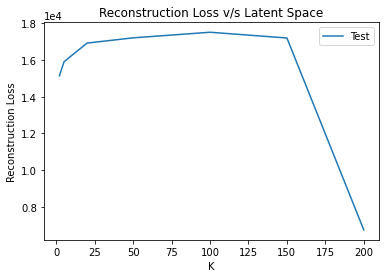

In [ ]:
plt.plot(num_latent_space, k_loss, label = "Test")

# plt.plot(num_latent_space, k_loss_train, label = "Train")

path = '../results/PCA/reconstuction_pca'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Reconstruction Loss')

plt.title('Reconstruction Loss v/s Latent Space')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.savefig(path)
plt.legend()
plt.show()

Plot reconstruction loss for each individual class

No handles with labels found to put in legend.


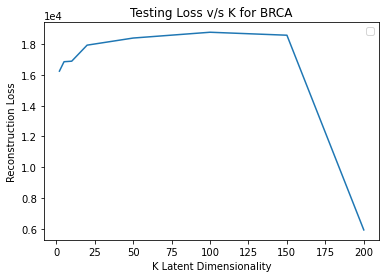

No handles with labels found to put in legend.


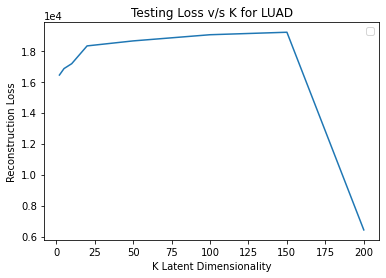

No handles with labels found to put in legend.


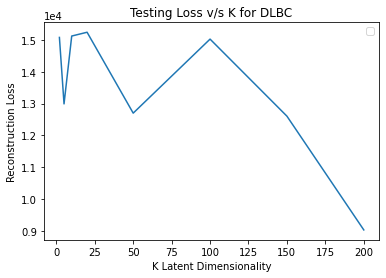

No handles with labels found to put in legend.


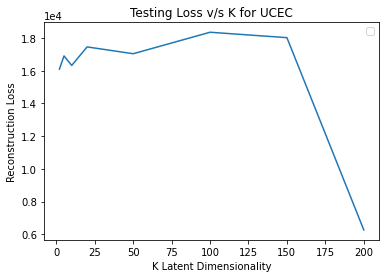

No handles with labels found to put in legend.


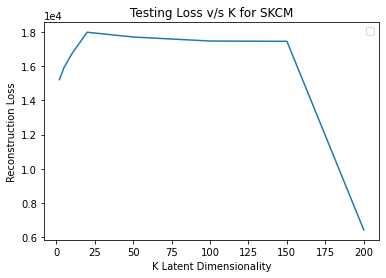

No handles with labels found to put in legend.


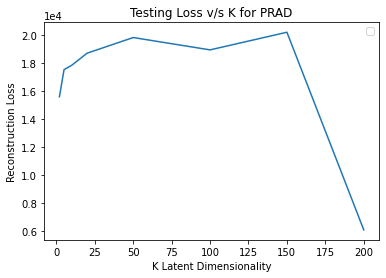

No handles with labels found to put in legend.


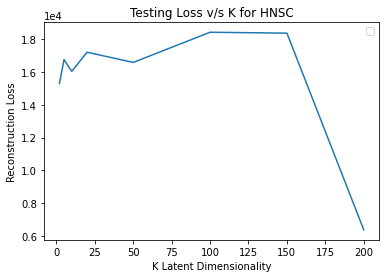

No handles with labels found to put in legend.


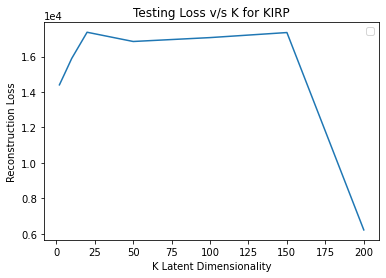

No handles with labels found to put in legend.


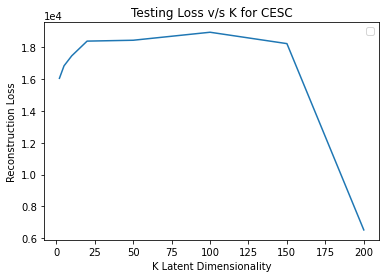

No handles with labels found to put in legend.


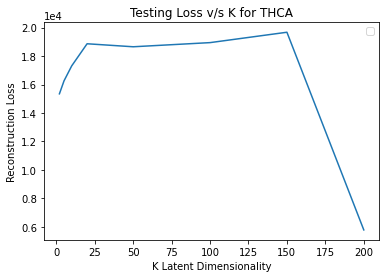

No handles with labels found to put in legend.


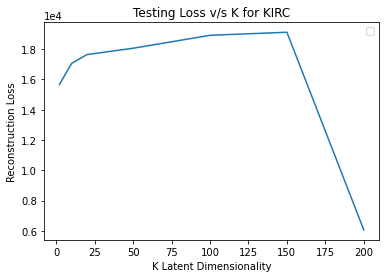

No handles with labels found to put in legend.


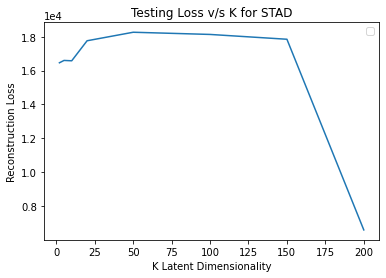

No handles with labels found to put in legend.


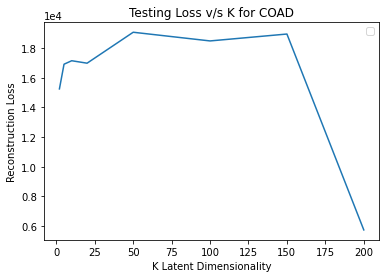

No handles with labels found to put in legend.


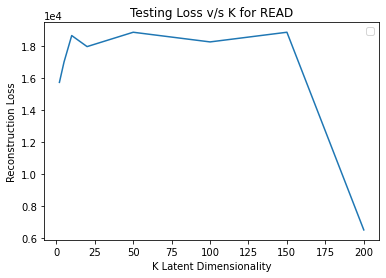

No handles with labels found to put in legend.


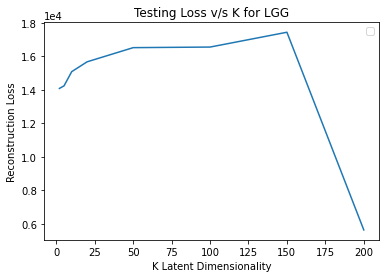

No handles with labels found to put in legend.


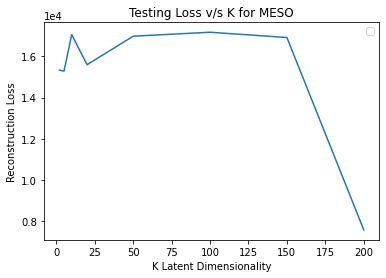

No handles with labels found to put in legend.


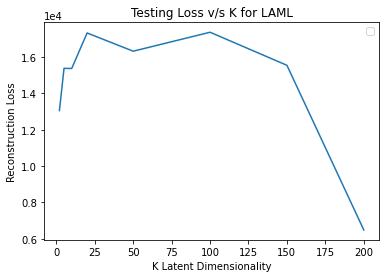

No handles with labels found to put in legend.


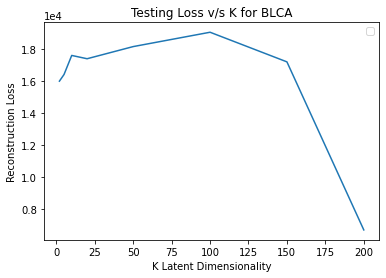

No handles with labels found to put in legend.


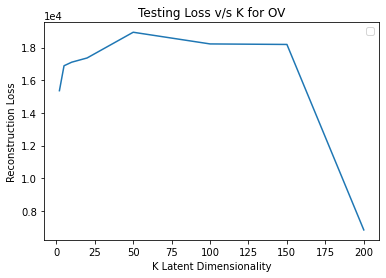

No handles with labels found to put in legend.


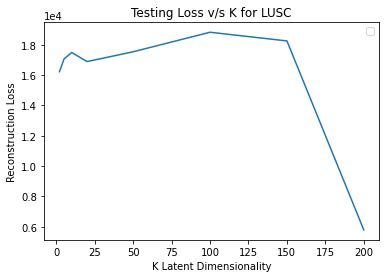

No handles with labels found to put in legend.


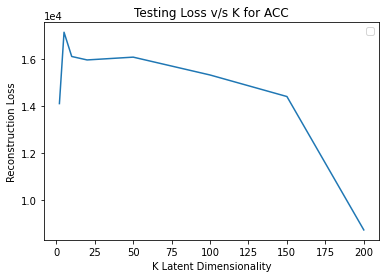

No handles with labels found to put in legend.


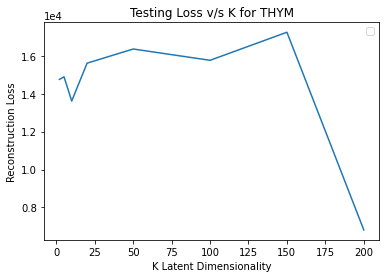

No handles with labels found to put in legend.


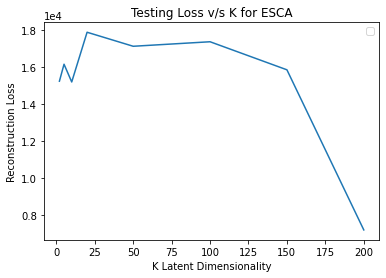

No handles with labels found to put in legend.


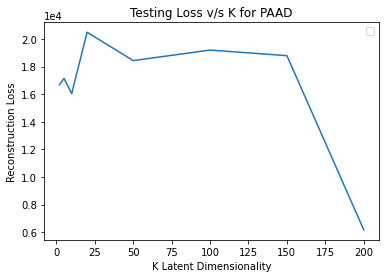

No handles with labels found to put in legend.


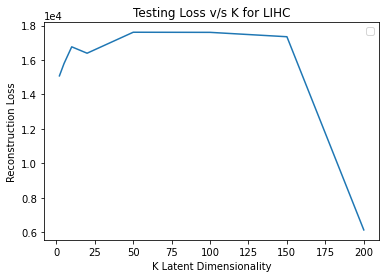

No handles with labels found to put in legend.


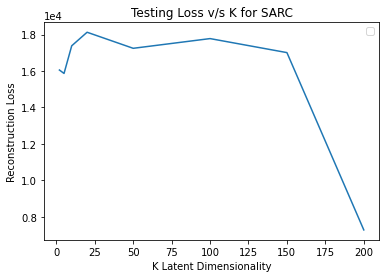

No handles with labels found to put in legend.


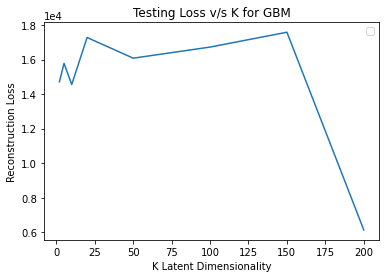

No handles with labels found to put in legend.


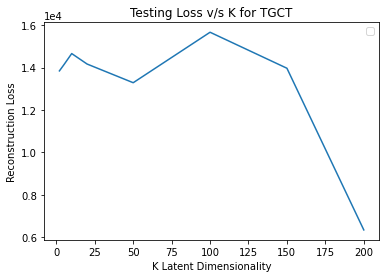

No handles with labels found to put in legend.


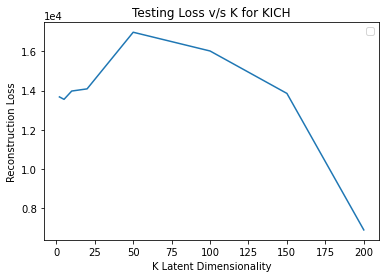

No handles with labels found to put in legend.


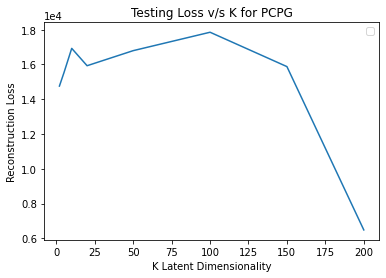

No handles with labels found to put in legend.


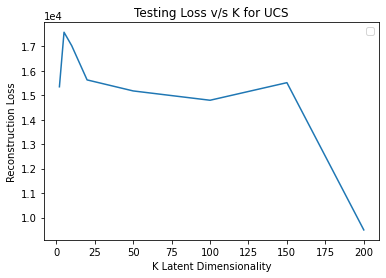

No handles with labels found to put in legend.


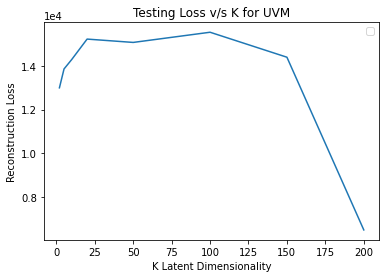

No handles with labels found to put in legend.


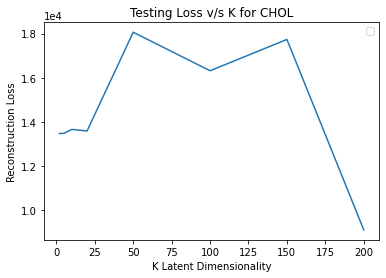

In [ ]:
# plot class wise reconstruction loss graph 
# clean_labels_for_class_wise_plot=['UCEC','SKCM','HNSC','THCA']
label=[]
for key in c_type_list:
    label.append(key)
class_wise_loss=np.array(class_wise_loss)
# class_wise_loss_train=np.array(class_wise_loss_train)
for ctype in range(len(c_type_list)):
    
    
    k_loss= class_wise_loss[:,ctype]
    plt.plot(num_latent_space, k_loss)


    # plt.plot(x2, y2, label = "Training")

    # naming the x axis
    plt.xlabel('K Latent Dimensionality')
    # naming the y axis
    plt.ylabel('Reconstruction Loss')
    # giving a title to my graph
    plt.title('Testing Loss v/s K for {}'.format(label[ctype]))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


    plt.legend()
    plt.show()

In [ ]:
def calc_pearson(input_df, reconstruct_mat):
    '''
    input_df - original dataframe
    reconstruct_mat - reconstructed matrix after pca
    '''   
    
    r = [pearsonr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]

    
    return r
    

For different values of k we obtain the pearson coeff and create a box plot for each class

In [ ]:
# calculate test pearson correlation values
num_latent_space= [2,5,10,20,50,100,150,200]

#testing correlation values
k_pearson =[]
class_wise_pearson=[]

for k in num_latent_space:
    print(k)
    class_corr=[]
    for c_type in c_type_list:
        #mse loss
        pearson=calc_pearson(k,c_type,test=True)
        class_corr.append(pearson)
        
    class_wise_pearson.append(class_corr)
    
print(np.array(class_wise_pearson).shape)


2
5
10
20
50
100
150
200
(8, 33)


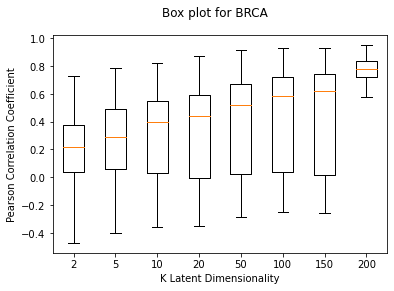

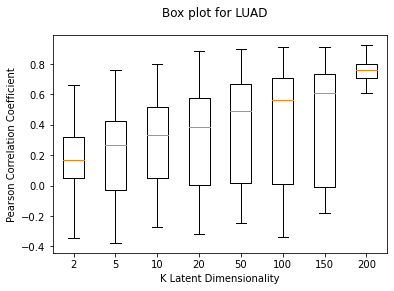

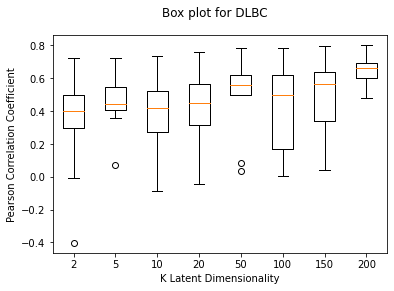

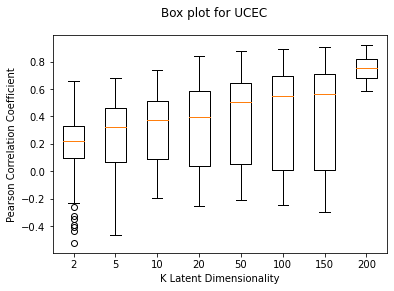

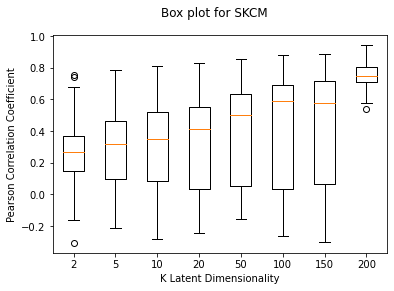

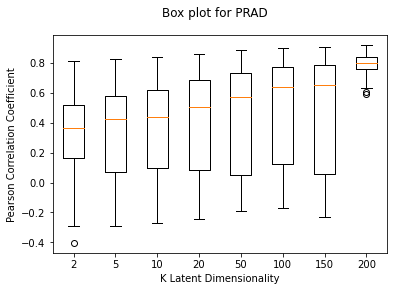

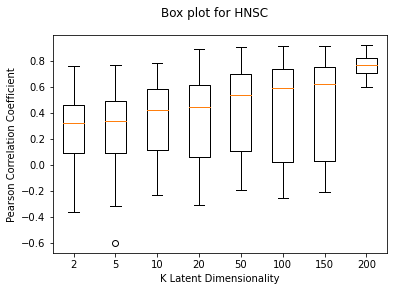

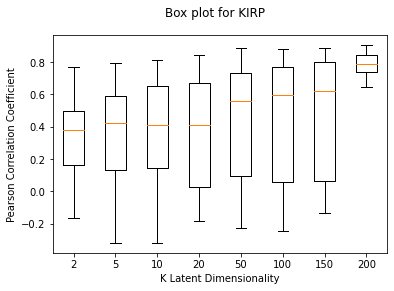

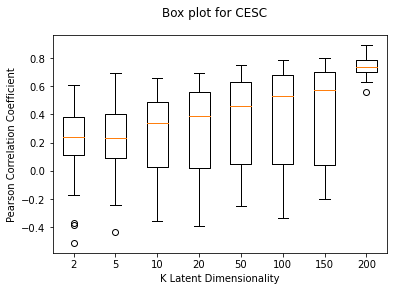

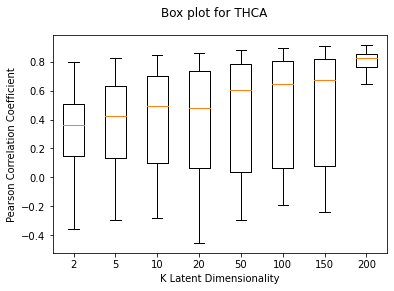

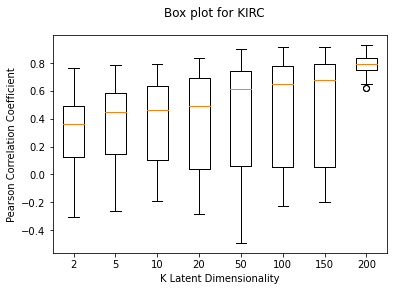

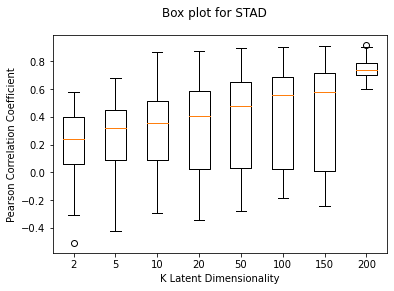

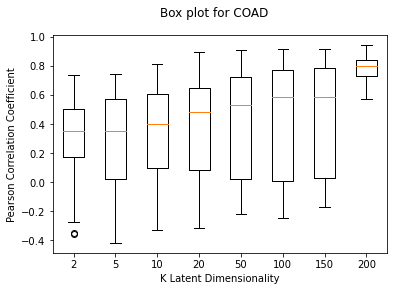

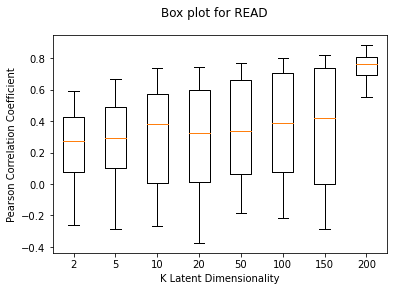

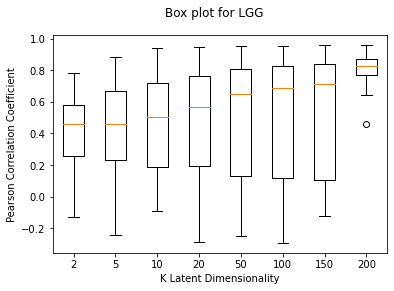

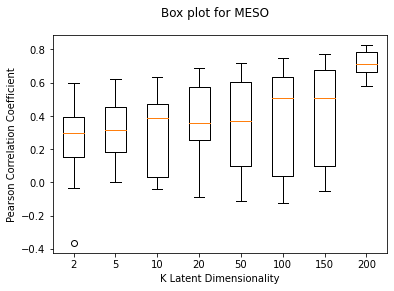

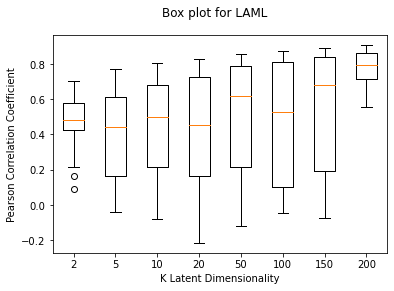

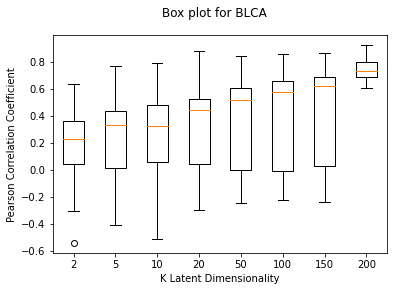

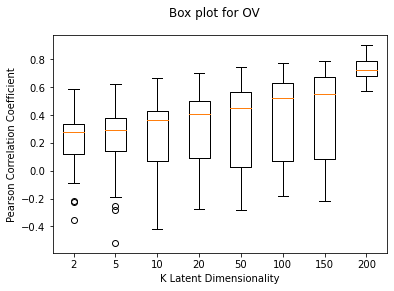

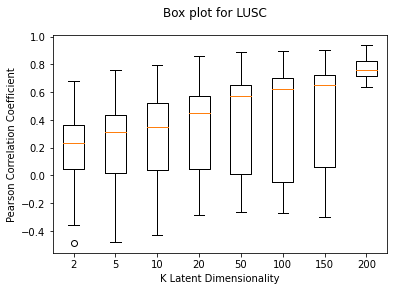

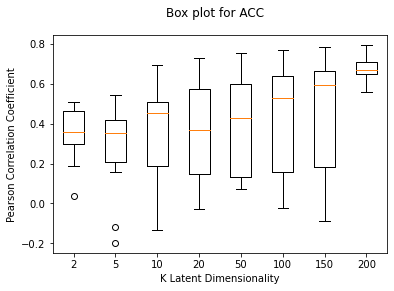

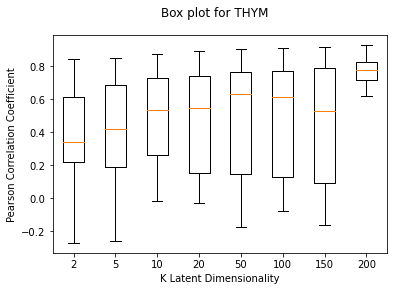

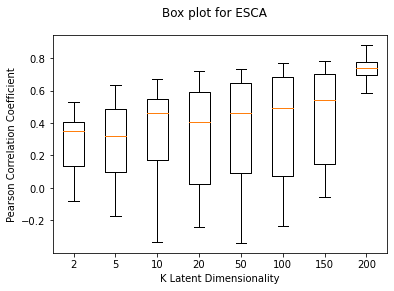

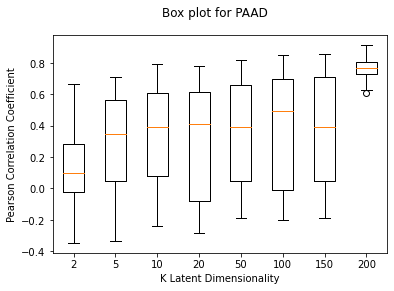

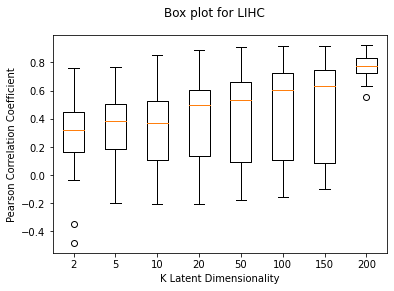

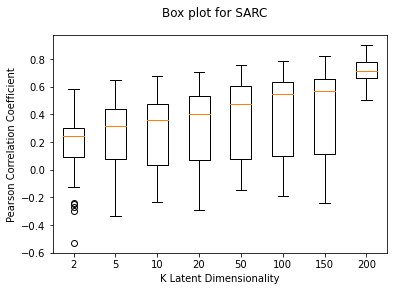

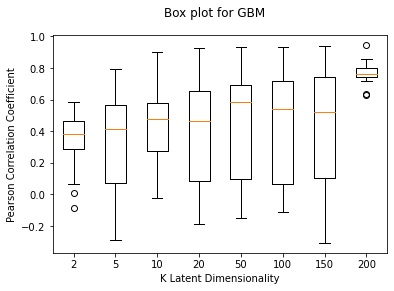

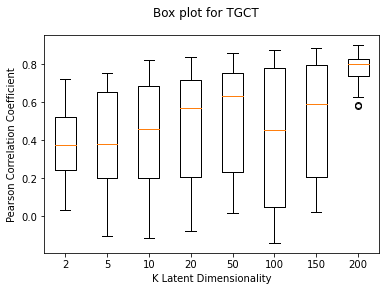

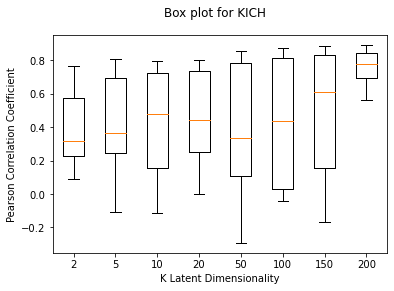

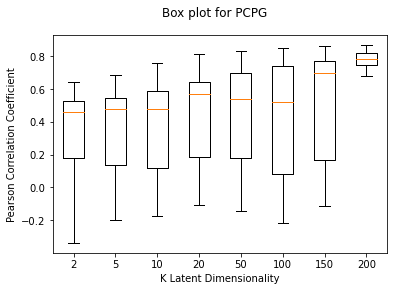

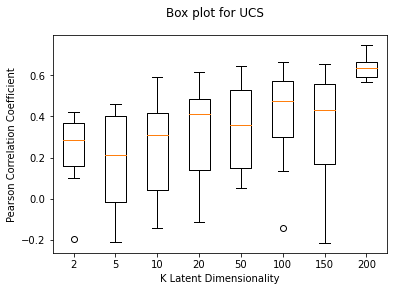

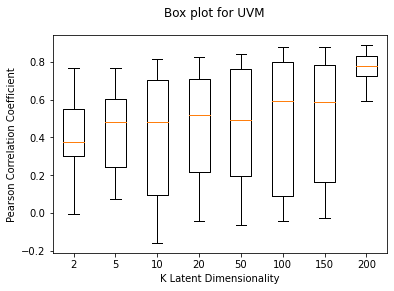

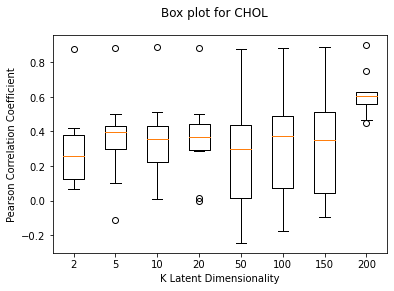

In [ ]:
label=[]
for key in c_type_list:
    label.append(key)
class_wise_pearson=np.array(class_wise_pearson)

num_latent_space=np.array(num_latent_space)
c_pearson=[]

for j in range(0,len(c_type_list)):
    c_pearson=[]
    for i in range(0,len(num_latent_space)):
        a=class_wise_pearson[i][j]
        c_pearson.append(a)
        
    # plot the box plot of the calculated pearson values
    c_pearson= np.array(c_pearson)
    fig, ax = plt.subplots() 
    fig.suptitle('Box plot for '+ label[j]) 
    ax.set_xlabel('K Latent Dimensionality') 
    ax.set_ylabel('Pearson Correlation Coefficient') 
    ax.boxplot(np.transpose(c_pearson), labels= num_latent_space) 
    #     fig.savefig(pearson_path)
    #     fig.clear(True) 

Function to calculate spearman coefficient for each sample between the original and reconstructed matrices

In [ ]:
def calc_spearman(input_df, reconstruct_mat):
    '''
    input_df - original dataframe
    reconstruct_mat - reconstructed matrix after pca
    '''
    s = [spearmanr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]

    return s
    

For different values of k we obtain the spearman coeff and create a box plot for each class

In [ ]:
# calculate test spearman correlation values
num_latent_space= [2,5,10,20,50,100,150,200]

#testing correlation values
k_spearman =[]
class_wise_spearman=[]

for k in num_latent_space:
    print(k)
    class_corr=[]
    for c_type in c_type_list:
        #mse loss
        spearman=calc_spearman(k,c_type,test=True)
        class_corr.append(spearman)
        
    class_wise_spearman.append(class_corr)
    
print(np.array(class_wise_spearman).shape)

2
5
10
20
50
100
150
200
(8, 33)


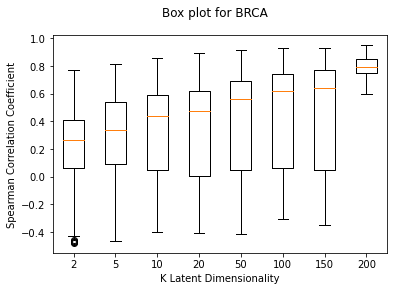

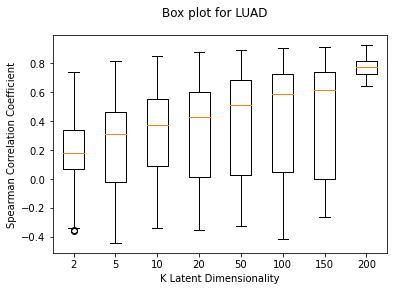

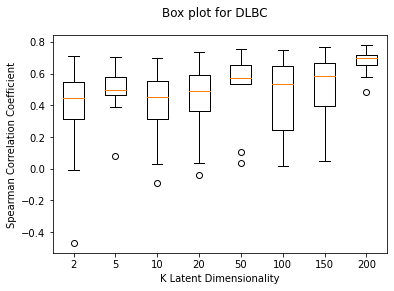

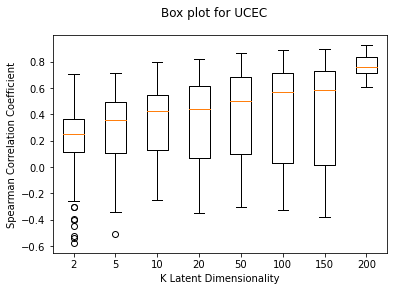

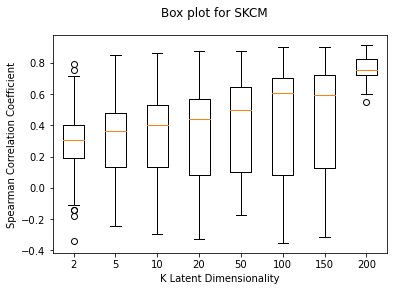

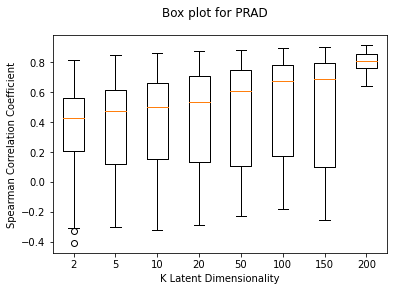

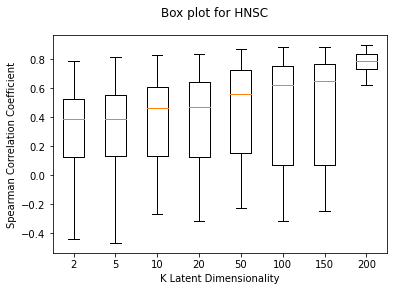

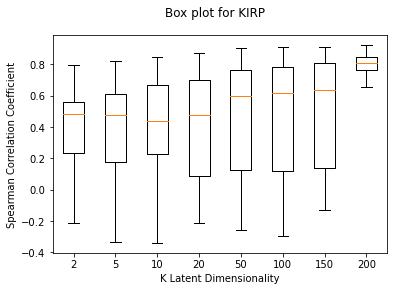

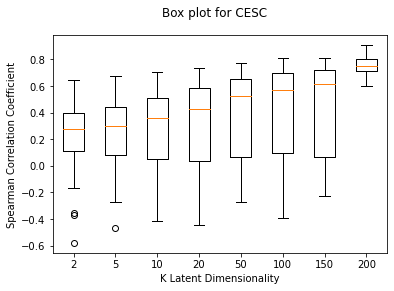

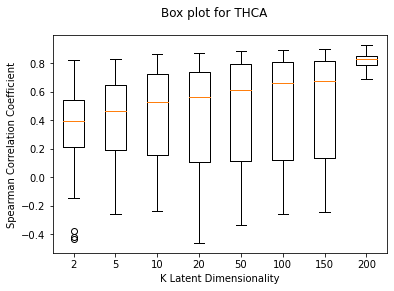

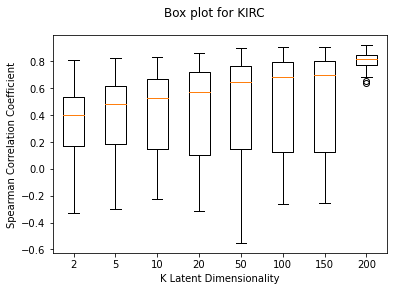

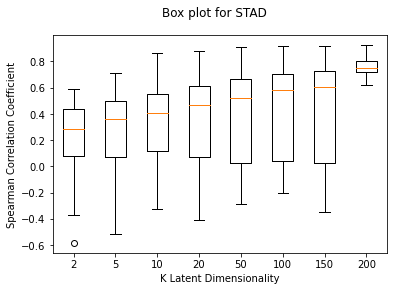

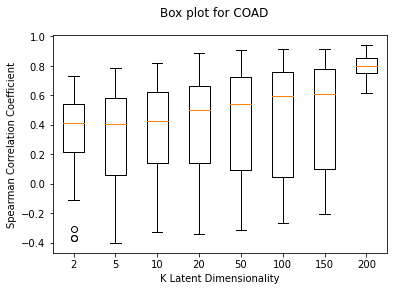

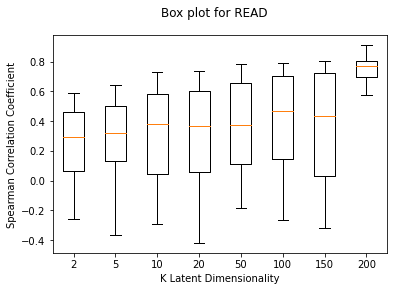

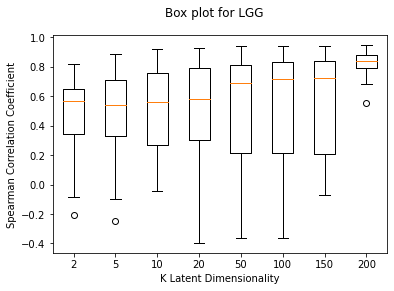

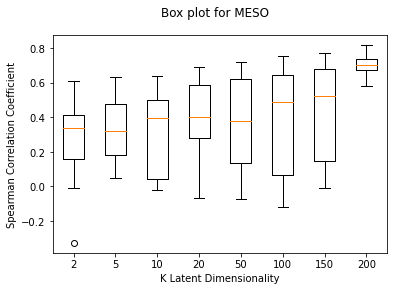

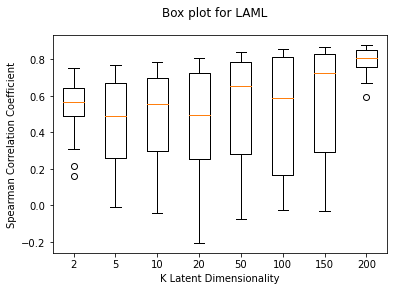

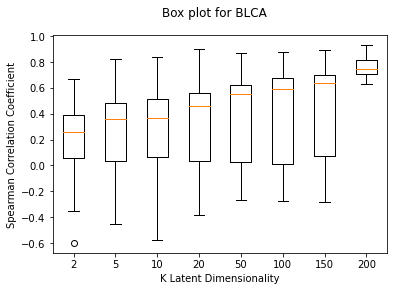

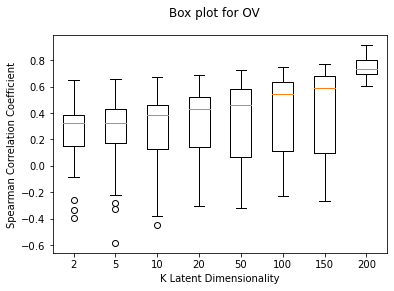

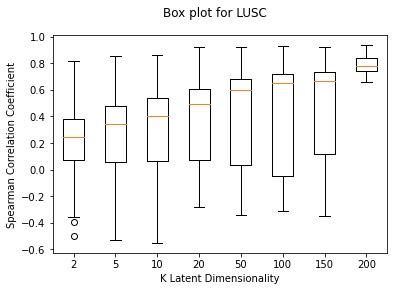

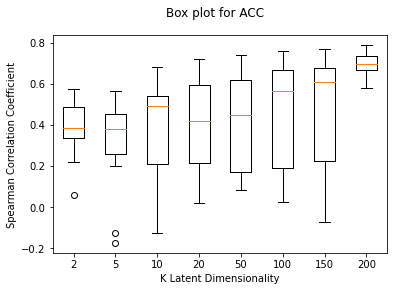

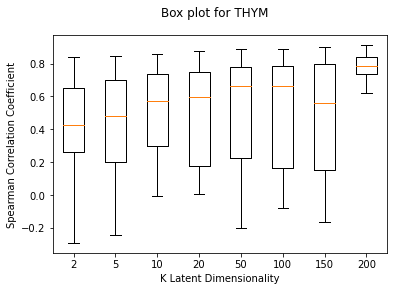

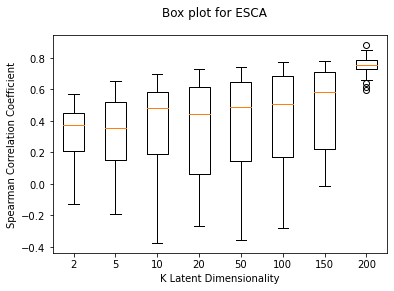

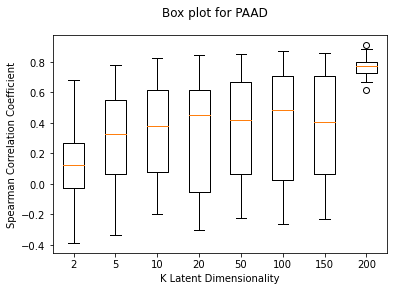

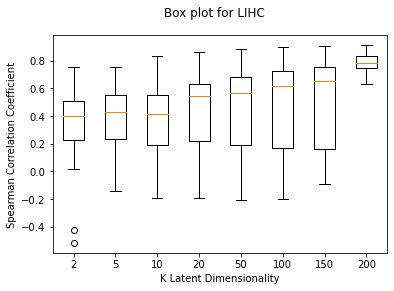

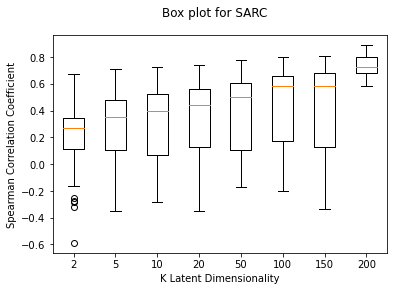

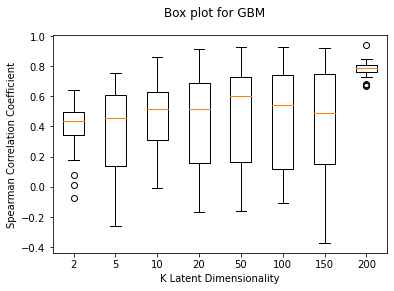

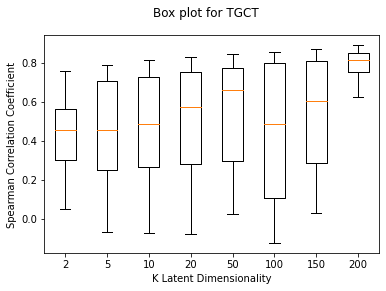

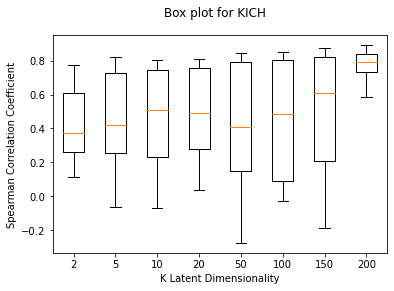

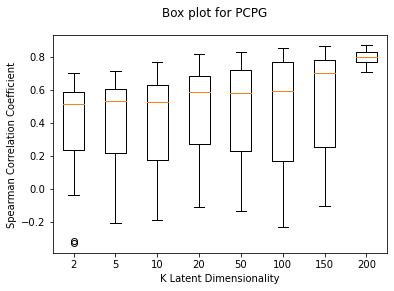

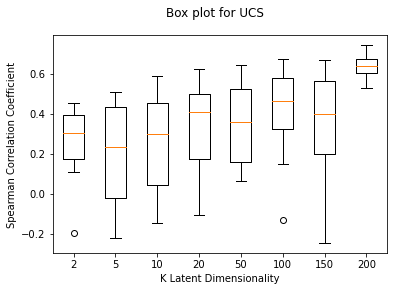

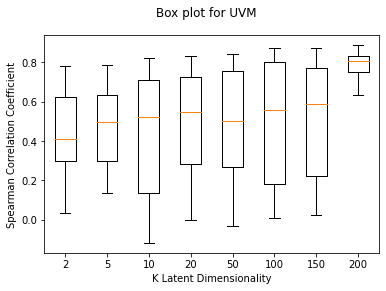

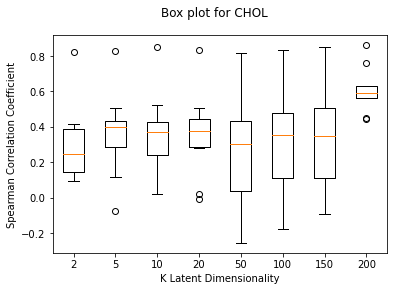

In [ ]:
# plot class wise spearman correlation graph 
# clean_labels_for_good_plot= ['BRCA','BLCA','LUSC','THCA']
label=[]
for key in c_type_list:
    label.append(key)
class_wise_spearman=np.array(class_wise_spearman)

num_latent_space=np.array(num_latent_space)
c_spearman=[]

for j in range(0,len(c_type_list)):
    c_spearman=[]
    for i in range(0,len(num_latent_space)):
        a=class_wise_spearman[i][j]
        c_spearman.append(a)
        
    # plot the box plot of the calculated pearson values
    c_spearman= np.array(c_spearman)
    fig, ax = plt.subplots() 
    fig.suptitle('Box plot for '+ label[j]) 
    ax.set_xlabel('K Latent Dimensionality') 
    ax.set_ylabel('Spearman Correlation Coefficient') 
    ax.boxplot(np.transpose(c_spearman), labels= num_latent_space) 
    #     fig.savefig(pearson_path)
    #     fig.clear(True) 
    

## Multiclass Regression

Similar to function returnDf2, we define a function that returns label encoded dataframe with 33 classes

In [ ]:
from sklearn import preprocessing
def multi_returnDf2(df, ind):
    '''
    df - input df to rename classes on (train_df or test_df)
    ind - either merge_trian or merge_test

    '''

    #drop sample_id (not needed as we have already appended the cancer type from labels)
    df2  = df.drop(['sample_id'], axis=1)

    le = preprocessing.LabelEncoder()
    df2['cancer_type'] = le.fit_transform(df2['cancer_type'])


    #Shuffle df2
    df2 = df2.sample(frac=1).reset_index(drop=True)

    return df2

Cell to perform PCA data compression on the input dataframe for different values of k - the number of reduced components for all classes

In [ ]:
#obtain all the different values of cancer types
c_type_list = collections.Counter(merge_train)

#Columns of resultant dataframe, and create it
cols = ['Full-data acc.', 'Full-data comp. time', 'NMF components', 'NMF calc. time', 'NMF acc.','Precision', 'Recall', 'F1Score', 'Train Reconstruction Loss','Test Reconstruction Loss', 'Pearson Coeff', 'Spearman Coeff']

results_df_multi = pd.DataFrame(columns = cols)
i = 0

#List of different values of k
num_latent_space= [2,5,10,20,50,100]

#Define empty lists to hold results in
class_wise_loss_test_multi=[]

class_wise_loss_train_multi=[]

class_wise_pearson_multi=[]

class_wise_spearman_multi=[]

#Outer loop with number of reduced dimensions
for k in num_latent_space:

    print(str(k))
    # train_data
    df2 = multi_returnDf2(train_tcga_df, merge_train)
    #test data
    test2 = multi_returnDf2(test_tcga_df, merge_test)
    # run LR on Entire datasaet 
    accuracy, time_laps = runLR(df2, test2)

    result_train, result_test = PCA_scale(df2, test2)
    
    # calculate PCA and reconstruction 
    reconstruct_mat_train, reconstruct_mat_test, pca_comp_train, pca_comp_test, pca_time, pca = returnPCA(result_train, result_test, 'LUAD', k)
    
    # get train test split
    train_x,test_x,train_y,test_y = prepPCAClassifier(df2, test2, pca_comp_train, pca_comp_test)
    print(train_x.shape[1])
    
    # run LR on PCA components
    pca_acc, pca_time, precision, recall, f1score = PCAClassifier(train_x, train_y, test_x, test_y)

    loss_train=calc_reconstruct_loss(result_train, reconstruct_mat_train)
    class_wise_loss_train_multi.append(loss_train)

    loss_test=calc_reconstruct_loss(result_test, reconstruct_mat_test)
    class_wise_loss_test_multi.append(loss_test)

    pearson=calc_pearson(result_test, reconstruct_mat_test)
    class_wise_pearson_multi.append(pearson)

    spearman=calc_spearman(result_test, reconstruct_mat_test)
    class_wise_spearman_multi.append(spearman)
    
    #Append all results to dataframe
    results_df_multi.loc[i] = [accuracy,time_laps, pca_comp_test.shape[1],pca_time,  pca_acc,precision, recall, f1score, loss_train, loss_test, pearson, spearman ]

    #Delete all calculated results to free RAM
    del reconstruct_mat_train
    del reconstruct_mat_test
    del nmf_comp_train
    del nmf_comp_test
    del nmf_time
    del result_train
    del result_test
    del df2
    del test2
    
    i = i+1


20
20


Print size and contents of pca_comp for a specfic value of k

In [ ]:

print(pca_comp_train.shape)
print(pca_comp_test)




(9954, 20)
          pca_0      pca_1      pca_2      pca_3      pca_4      pca_5  \
0    -41.661198  13.708911  25.262249   4.655219  24.461311 -17.117504   
1     24.710223  -1.692131  -2.342123   6.014584  -2.088492 -15.029151   
2    -13.122714  11.331528  13.123496  13.044698 -16.635241 -10.224247   
3    -48.985579  15.716876  14.723231  14.270873  28.479211 -22.751496   
4    -49.900209 -50.192425 -43.926897  74.747535  47.464588  53.342560   
...         ...        ...        ...        ...        ...        ...   
1101 -14.233150  18.939275  18.619713  -6.591351  24.724206 -21.802672   
1102  11.657405 -24.029139 -29.623776 -12.608389  25.798733   3.884498   
1103 -35.054041 -16.243679  11.613055 -10.555590  39.285819 -10.272053   
1104  16.449657 -40.803378 -13.146254 -17.213652 -33.025128  -9.408005   
1105 -26.812890  16.066717 -40.031783   5.227331   0.424133  -9.972350   

          pca_6      pca_7      pca_8      pca_9     pca_10     pca_11  \
0     12.843217  -5.007225

Define and run function to generate scores-loading biplot

(16148, 2)


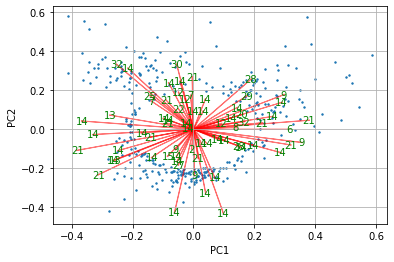

In [ ]:
def myplot(score,coeff,labels=None):
    xs = score.iloc[:,0]
    ys = score.iloc[:,1]
    n = labels.shape[0]
    print(coeff.shape)
    coeff1 = coeff[:,0]
    coeff2 = coeff[:,1]
    scalecoeff1 = 1.0/(coeff1.max() - coeff1.min())
    scalecoeff2 = 1.0/(coeff2.max() - coeff2.min())
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    idx = ((xs*scalex)**2+ (ys*scaley)**2)>0.04
    xs_new= xs[idx]
    ys_new= ys[idx]
    plt.scatter(xs_new * scalex,ys_new * scaley, s=2)
    
    for i in range(n):
        if ((abs(xs[i]*scalex)>0.4) or (abs(ys[i]*scaley) >0.3)):
            plt.arrow(0, 0, coeff[i,0]*scalecoeff1, coeff[i,1]*scalecoeff2,color = 'r',alpha = 0.5)
            if labels is None:
                plt.text(coeff[i,0]* scalecoeff1, coeff[i,1] * scalecoeff2, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
            else:
                plt.text(coeff[i,0]* scalecoeff1, coeff[i,1] * scalecoeff2, labels[i], color = 'g', ha = 'center', va = 'center')

    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()


myplot(pca_comp_test.iloc[:,0:2], np.transpose(pca.components_[0:2,:]),test_y)
plt.show()